Run locally or <a target="_blank" href="https://colab.research.google.com/github/aalgahmi/dl_handouts/blob/main/00.5-REVIEW-explainable_ai_and_hyperparameter_tuning.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**IMPORTANT NOTE**: This handout notebook relies on functions from the **for-this-class-only** `mylib` package. To access this package, clone or download it from **[this GitHub page](https://github.com/aalgahmi/mylib)**. You can find instructions on how to clone this package on its main GitHub page, as well as in the `04.working_with_datasets.ipynb` notebook handout. Make sure to place the `mylib` folder from this package in the same directory as this notebook. Once you've completed this step, the following import should work seamlessly.

In [2]:
import mylib as my

# 16: Explainable AI and Hyperparameter tuning

## Explainable AI (XAI)
While there is no universal consensus on the definition of interpretability in machine learning, model interpretability/explainability is often described as the degree to which humans can understand the reasons behind a model's decisions and whether they can consistently predict the model's results.

There are various techniques for understanding how models make predictions, and they can be categorized as either model-specific or model-agnostic. Many of these techniques establish a connection between a model's output and its input by calculating feature importance. Feature importance measures how much a particular feature contributes to a prediction and can be either local or global. Local feature importance values indicate the contribution of features in a single example to the determination of its predicted value.

To see how all of this works, we'll use the wine dataset. First, we'll employ a model-specific method to calculate global feature importance using a random forest. Afterward, we will delve into two model-agnostic techniques: permutation-based feature importance and SHAP values.

Let's begin by loading the data:

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df.columns = [
    'y', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 
    'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
    'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline'
]

As you see, the first column is the output column. Let's move it to the end.

In [4]:
df = df[[*df.columns[1:], df.columns[0]]]
df

Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  Total phenols  \
0      14.23        1.71  2.43               15.6        127           2.80   
1      13.20        1.78  2.14               11.2        100           2.65   
2      13.16        2.36  2.67               18.6        101           2.80   
3      14.37        1.95  2.50               16.8        113           3.85   
4      13.24        2.59  2.87               21.0        118           2.80   
..       ...         ...   ...                ...        ...            ...   
173    13.71        5.65  2.45               20.5         95           1.68   
174    13.40        3.91  2.48               23.0        102           1.80   
175    13.27        4.28  2.26               20.0        120           1.59   
176    13.17        2.59  2.37               20.0        120           1.65   
177    14.13        4.10  2.74               24.5         96           2.05   

     Flavanoids  Nonflavanoid phenols  Proanthocyanins  Color intensity   Hue  \
0          3.06                  0.28             2.29             5.64  1.04   
1          2.76                  0.26             1.28             4.38  1.05   
2          3.24                  0.30             2.81             5.68  1.03   
3          3.49                  0.24             2.18             7.80  0.86   
4          2.69                  0.39             1.82             4.32  1.04   
..          ...                   ...              ...              ...   ...   
173        0.61                  0.52             1.06             7.70  0.64   
174        0.75                  0.43             1.41             7.30  0.70   
175        0.69                  0.43             1.35            10.20  0.59   
176        0.68                  0.53             1.46             9.30  0.60   
177        0.76                  0.56             1.35             9.20  0.61   

     OD280/OD315 of diluted wines  Proline  y  
0                            3.92     1065  1  
1                            3.40     1050  1  
2                            3.17     1185  1  
3                            3.45     1480  1  
4                            2.93      735  1  
..                            ...      ... ..  
173                          1.74      740  3  
174                          1.56      750  3  
175                          1.56      835  3  
176                          1.62      840  3  
177                          1.60      560  3  

[178 rows x 14 columns]

Let's split it into training and testing portions. This time we are passing Pandas' dataframes to the `train_test_split()` function.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1].values, df.iloc[:, -1].values, test_size=0.2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((142, 13), (142,), (36, 13), (36,))

This dataset has multiple input features as well as a categorical output.

### Model-specific feature importance using random forests

Next, we use a random forest model. We tune some of its hyper parameters, namely: `n_estimators`, `max_depth`, and `max_features` using SciKit Learn's randomized search.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(random_state=0)

parameters = {
    'n_estimators': range(20, 200, 10), 
    'max_depth': range(1, 11), 
    'max_features': [None, 'sqrt', 'log2']
}

rs = RandomizedSearchCV(rf, parameters)
rs.fit(X_train, y_train)


rs.best_score_, rs.best_params_

(0.9862068965517242,
 {'n_estimators': 90, 'max_features': 'log2', 'max_depth': 7})

Let's train a random forest model using these best values.

In [7]:
rf = RandomForestClassifier(random_state=0, 
                            max_depth=rs.best_params_['max_depth'], 
                            max_features=rs.best_params_['max_features'],
                            n_estimators=rs.best_params_['n_estimators'])
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features='log2', n_estimators=90,
                       random_state=0)

Let's evaluate this model using the testing set, display its confusion matrix, and print its accuracy, and micro and macro f1 scores.

Testing accuracy:  0.9444444444444444
Testing micro f1 score:  0.9444444444444444
Testing macro f1 score:  0.9449112978524742


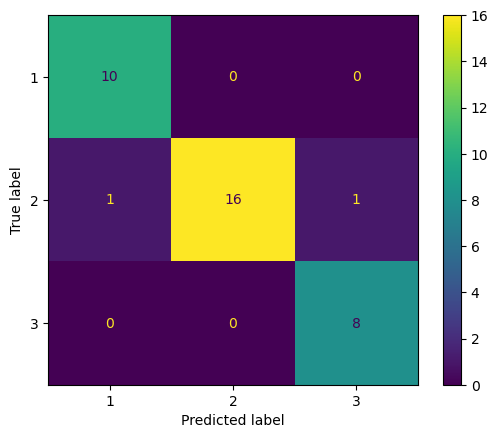

In [8]:
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)

print('Testing accuracy: ', accuracy_score(y_test, rf.predict(X_test)))
print('Testing micro f1 score: ', f1_score(y_test, rf.predict(X_test), average="micro"))
print('Testing macro f1 score: ', f1_score(y_test, rf.predict(X_test), average="macro"))

One great feature of decision trees and random forests is their ability to calculate the importance of a feature using node impurity. According to Scikit-Learn's documentation, 'Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average, across all trees in the forest. More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. Let's see which feature(s) of the above random forest is more important'.

Here are the importance values next their corresponding features:

In [9]:
for importance, name in zip(rf.feature_importances_, df.columns[:-1]):
    print(round(importance, 3), name)

0.106 Alcohol
0.044 Malic acid
0.009 Ash
0.019 Alcalinity of ash
0.026 Magnesium
0.065 Total phenols
0.196 Flavanoids
0.01 Nonflavanoid phenols
0.028 Proanthocyanins
0.134 Color intensity
0.08 Hue
0.118 OD280/OD315 of diluted wines
0.165 Proline


These values are the means of feature importances of each of the underlying trees. In other words, they can be calculated manually as:

In [10]:
np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0)

array([0.1055012 , 0.0441806 , 0.0090852 , 0.01869072, 0.02648364,
       0.06496497, 0.19558008, 0.01021576, 0.02847884, 0.13386937,
       0.07954027, 0.11843765, 0.1649717 ])

Here is how to print and plot these values.

Text(0.5, 1.0, 'Impurity-based feature importance')

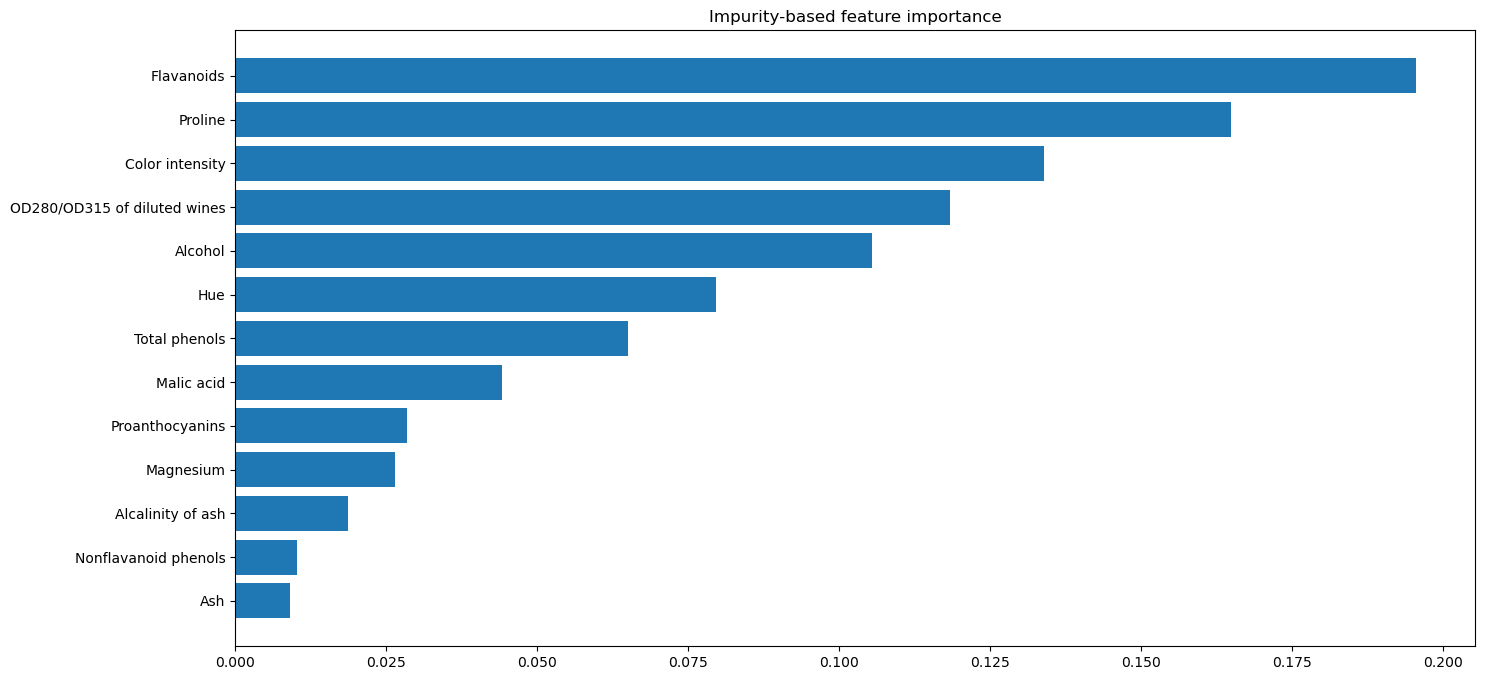

In [11]:
importances = rf.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), df.columns[:-1][indices])
plt.title('Impurity-based feature importance')

Or we can also plot this data vertically like this:

Text(0.5, 1.0, 'Impurity-based feature importance')

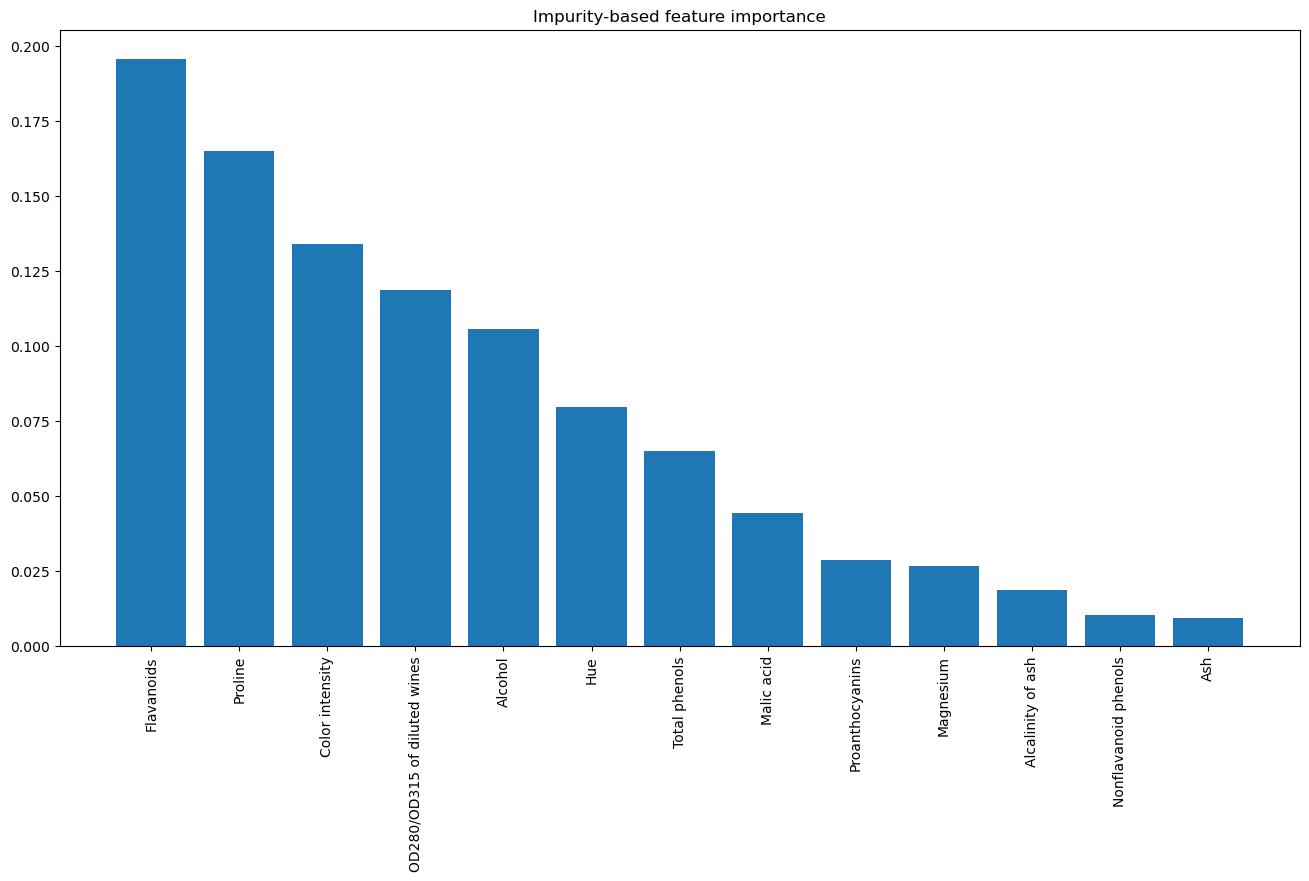

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.bar(range(X_train.shape[1]), importances[indices[::-1]], align='center')
plt.xticks(range(X_train.shape[1]), df.columns[:-1][indices[::-1]], rotation=90)
plt.title('Impurity-based feature importance')

This tells us that the following are the top three features with the most say on the output of this model.

In [13]:
df.columns[:-1][indices[::-1][:3]]

Index(['Flavanoids', 'Proline', 'Color intensity'], dtype='object')

Because the above values are means of the importance values of the underlying trees, you might want to also plot how spread out the underlying tree values are. For that we need to also calculate the standard deviation of these values and add them to the plot.

Since the above values are the means of the importance values from the underlying trees, it can be informative to visualize the spread or variability of these values. To achieve this, we need to calculate the standard deviation of these values and incorporate them into the plot.

Text(0.5, 1.0, 'Impurity-based feature importance')

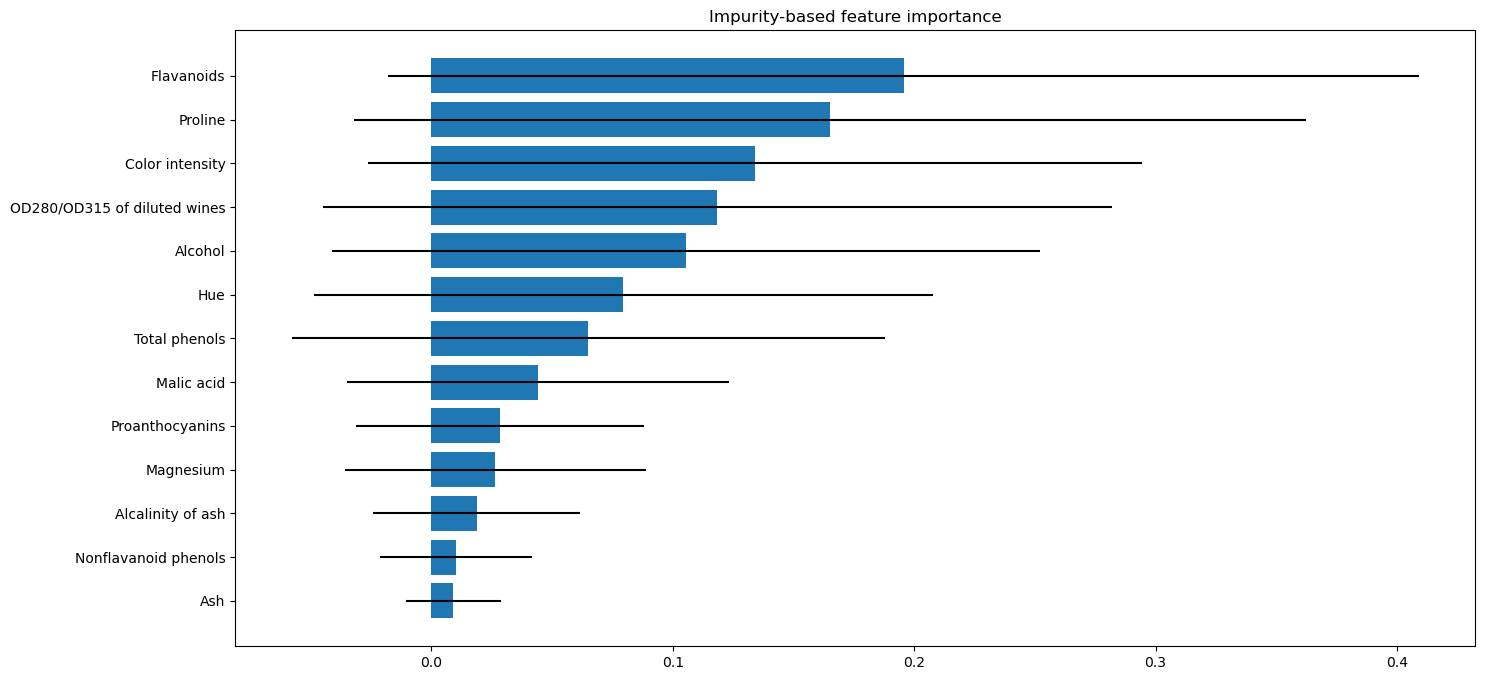

In [14]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.barh(range(X_train.shape[1]), importances[indices], align='center', xerr=std[indices])
plt.yticks(range(X_train.shape[1]), df.columns[:-1][indices])
plt.title('Impurity-based feature importance')

The lines on the plot illustrate the spread of importance values, and longer lines do not indicate a high level of agreement among the trees regarding the importance of a particular feature. This is expected since random forests use **feature bagging** to make the underlying trees as diverse as possible.

### Model-agnostic methods

Model-agnostic methods apply to all kinds of models. They treat the model as a **black box** and do not make any assumptions about its internal workings. An example of such methods is the permutation-based feature importance method implemented by SciKit Learn. This method generates numerous permutations of possible feature subsets and trains models on each of these subsets. It calculates the importance of a feature by assessing the mean decrease in accuracy when a feature is removed. However, due to the potentially vast number of feature subsets, this method can be computationally expensive large datasets with many features.

Now, let's see how we can utilize this method on the dataset and the random forest model above. This will allow us to compare the results of this method with those obtained from the impurity-based feature importance method described earlier.

In [15]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(rf, X_test, y_test, n_repeats=10)
perm.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

The `n_repeats` parameter specifies the number of times to permute a feature. By default `n_repeats` is 5. The `permutation_importance` function returns a dictionary. The the importance values for each feature per each permutation is.

In [16]:
perm['importances'].shape

(13, 10)

which indicates 13 features and 10 permutations per each.

The other items in the returned dictionary are `importances_mean` and `importances_std`, which are the means and standard deviations of the importances of each features across all permutations. 

In [17]:
perm['importances_mean'].shape, perm['importances_std'].shape

((13,), (13,))

Let's plot the mean importance values. We'll use the standard deviation values to indicate how these values are spreed out across the underlying permutations.

Text(0.5, 1.0, 'Permutation feature importance')

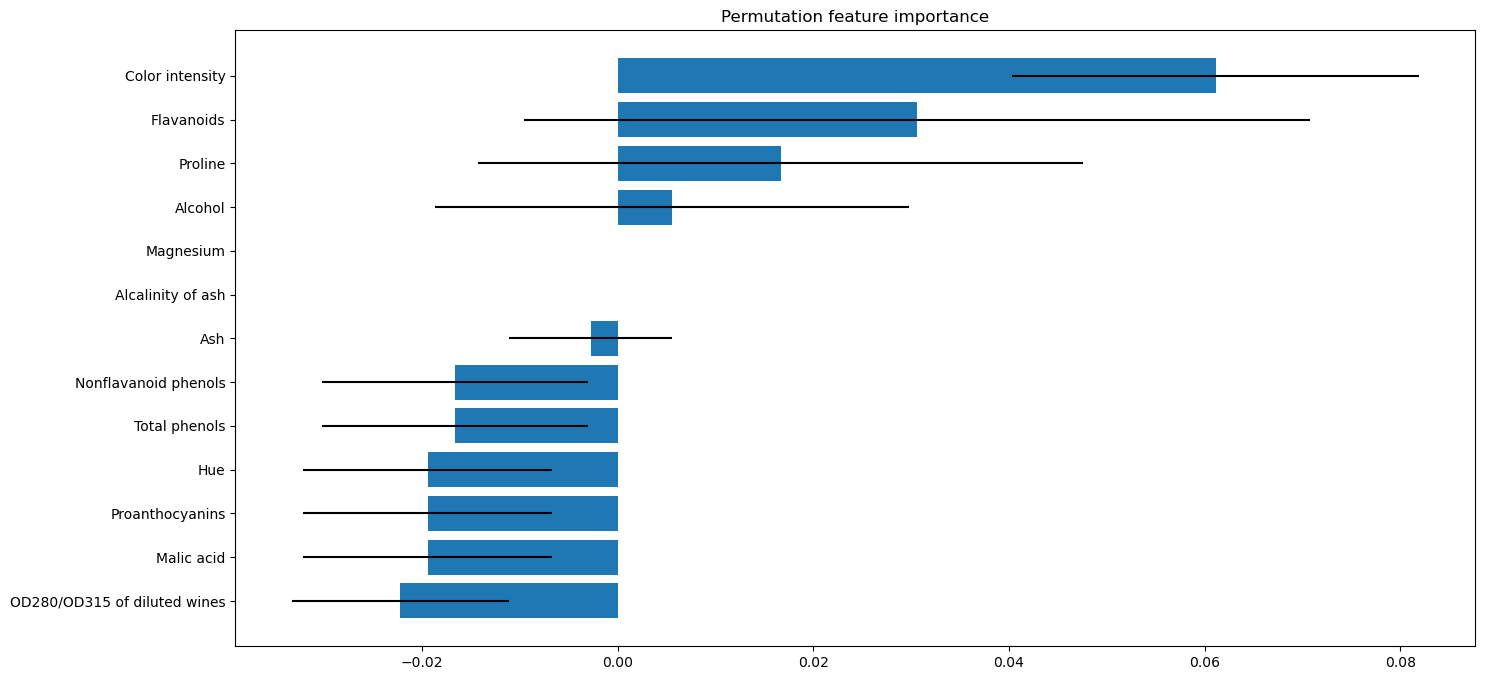

In [18]:
indices = indices = np.argsort(perm.importances_mean)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.barh(range(X_train.shape[1]), perm.importances_mean[indices], align='center', xerr=perm.importances_std[indices])
plt.yticks(range(X_train.shape[1]), df.columns[:-1][indices])
plt.title('Permutation feature importance')

As you can see, the top most important features are similar (but perhaps not the same) as before. Some of the less important features with show up with 0 importance.

### SHAP values
Next we explore the use of SHAP (Shapley Additive Explanations) values to explain machine learning models. This is one of the most popular model-agnostic methods for explaining ML models. SHAP is based on Shapley values from coalitional game theory, originally proposed by Lloyd Shapley in 1953.

Let's see how it works by using it to explain the above random forest model. Let's import it and initialize its JavaScript. We will see later that, `shap` needs JavaScript for some of its plots.

In [19]:
import shap
shap.initjs()

First we create an explainer object. There are many explainers to use. If you are not sure, use the class `shap.Explainer`. For this random forest model, we'll use `shap.TreeExplainer`.

The explainer object is then used to calculate shap values. If you are using NumPy arrays for data, pass feature names to the explainer using the `feature_names=` parameter. If you are using Pandas dataframes, then the feature names are already included.

In [20]:
feature_names = df.columns[:-1]
explainer = shap.TreeExplainer(rf, feature_names=feature_names)
shap_values = explainer.shap_values(X_test)

The returned `shap_values` is a list with three arrays: one for every class. Here is shape of the first array.

In [21]:
shap_values[0].shape

(36, 13)

which means there is a single shap value for every feature of every example for every class. 

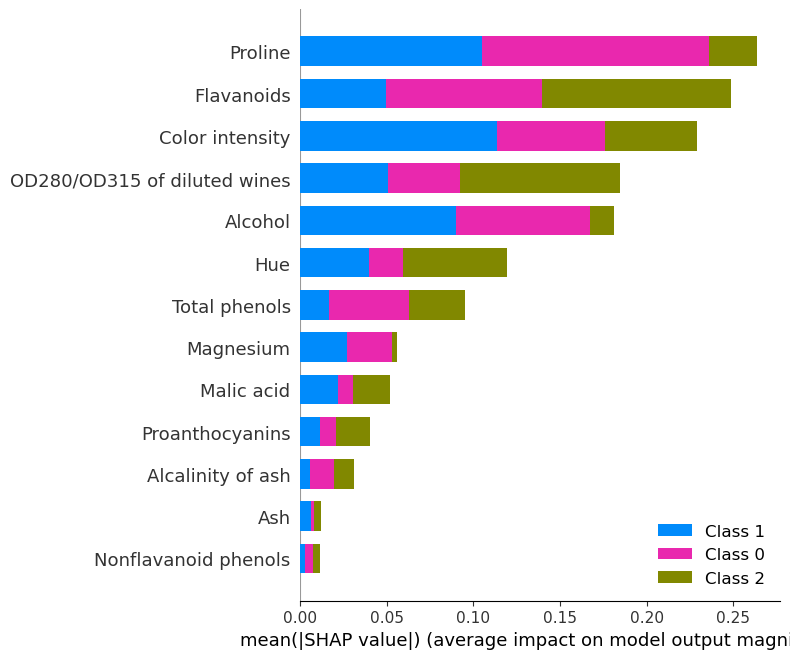

In [22]:
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

The summary plot summarizes the shap values across multiple examples. As you an see shap gives us more information than the above method. It breaks importance values(shap values) by class, which allows for a level of granularity that we did not have before. 

We can also explain the model's prediction for a single example, Say that we have a question about the following testing example:

In [23]:
example = X_test[9:10, :]
example.shape

(1, 13)

Let's use the above explainer to calculate its shap values.

In [24]:
example_shap_values = explainer.shap_values(example)
example_shap_values

[array([[-0.09663447, -0.01855084, -0.00267602,  0.00118281, -0.03544469,
          0.01572392, -0.01148794,  0.00169677,  0.00360444, -0.08868552,
          0.00835376,  0.01864255, -0.14376859]]),
 array([[ 1.05968316e-01,  4.00135495e-02,  1.05115556e-02,
         -7.27564783e-04,  3.47512196e-02, -2.32900873e-03,
          7.57937475e-02,  3.30207353e-05,  1.65120588e-03,
          1.45694030e-01,  4.03396167e-02,  4.82295871e-02,
          1.34499519e-01]]),
 array([[-0.00933384, -0.0214627 , -0.00783553, -0.00045525,  0.00069347,
         -0.01339491, -0.0643058 , -0.00172979, -0.00525565, -0.05700851,
         -0.04869338, -0.06687214,  0.00926907]])]

Again there is a list of three arrays (one per class). Now we can plot the importance values of this example.

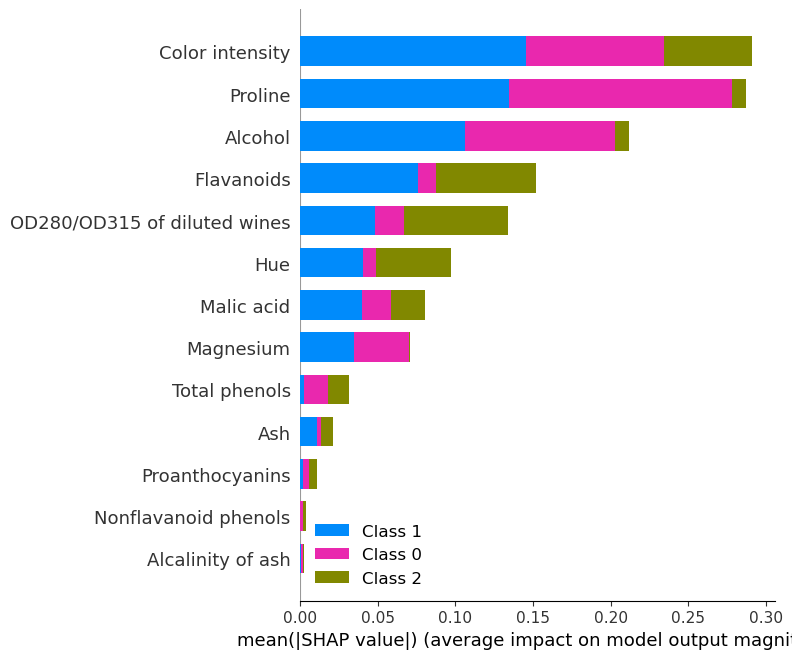

In [25]:
shap.summary_plot(example_shap_values, example, feature_names=feature_names)

Let's stay with this example. Shap values are additive by design. Here are the expected values of this model (one per class):

In [26]:
explainer.expected_value

array([0.34804382, 0.36557121, 0.28638498])

And here again are the predicted probabilities of this example (again one per class)

In [27]:
rf.predict_proba(example)

array([[0., 1., 0.]])

Next we ask the explainer to create an explanation for this example. An explanation is an object encompassing shap values, base (expected) values, original data, and feature names.

In [28]:
ex = explainer(example)
ex

.values =
array([[[-9.66344738e-02,  1.05968316e-01, -9.33384241e-03],
        [-1.85508449e-02,  4.00135495e-02, -2.14627046e-02],
        [-2.67602336e-03,  1.05115556e-02, -7.83553220e-03],
        [ 1.18281493e-03, -7.27564783e-04, -4.55250149e-04],
        [-3.54446876e-02,  3.47512196e-02,  6.93468012e-04],
        [ 1.57239174e-02, -2.32900873e-03, -1.33949087e-02],
        [-1.14879431e-02,  7.57937475e-02, -6.43058043e-02],
        [ 1.69677372e-03,  3.30207353e-05, -1.72979445e-03],
        [ 3.60444445e-03,  1.65120588e-03, -5.25565033e-03],
        [-8.86855182e-02,  1.45694030e-01, -5.70085122e-02],
        [ 8.35376177e-03,  4.03396167e-02, -4.86933785e-02],
        [ 1.86425499e-02,  4.82295871e-02, -6.68721370e-02],
        [-1.43768590e-01,  1.34499519e-01,  9.26907026e-03]]])

.base_values =
array([[0.34804382, 0.36557121, 0.28638498]])

.data =
array([[ 12.  ,   0.92,   2.  ,  19.  ,  86.  ,   2.42,   2.26,   0.3 ,
          1.43,   2.5 ,   1.38,   3.12, 278.  ]])

Here is a force plot that shows how the shap values add up to the difference between the model predicted value and the base (expected) value for the first class.

In [29]:
shap.force_plot(ex[0,:,0])

And here is it for the second and third classes:

In [30]:
shap.plots.force(ex[0,:,1])

In [31]:
shap.plots.force(ex[0,:,2])

The force plots are condensed plots. We can use waterfall plots to look at single explanations. Here are the equivalent waterfall plots for the above force plots. Here is the one for the first class.

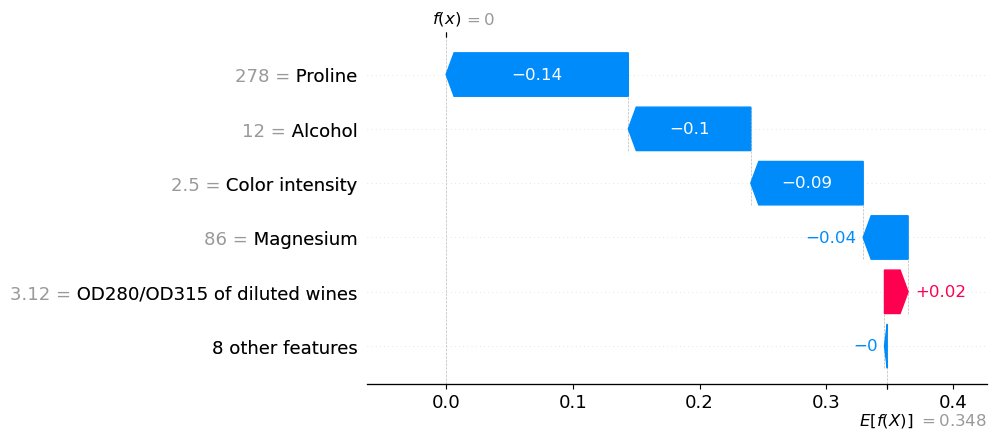

In [32]:
shap.waterfall_plot(ex[0,:,0], max_display=6)

The `max_display=` parameter indicates how many feature rows to plot. Here are the waterfall plots for the other two classes.

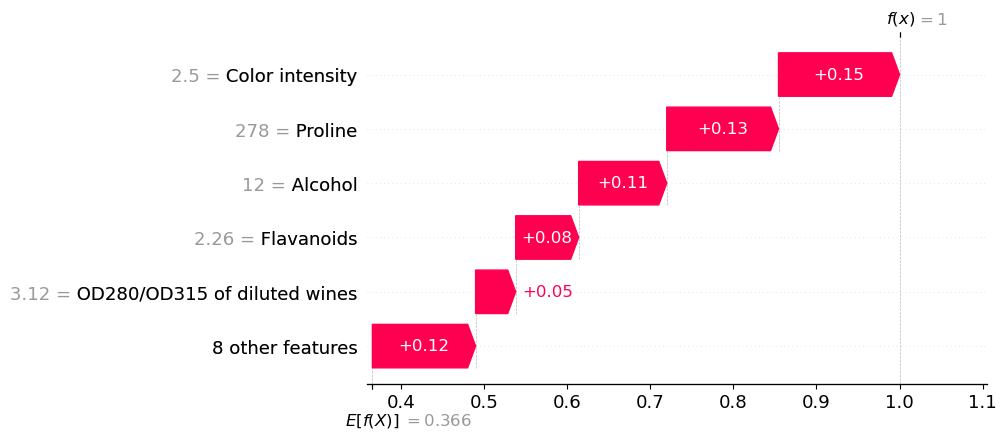

In [33]:
shap.plots.waterfall(ex[0,:,1], max_display=6)

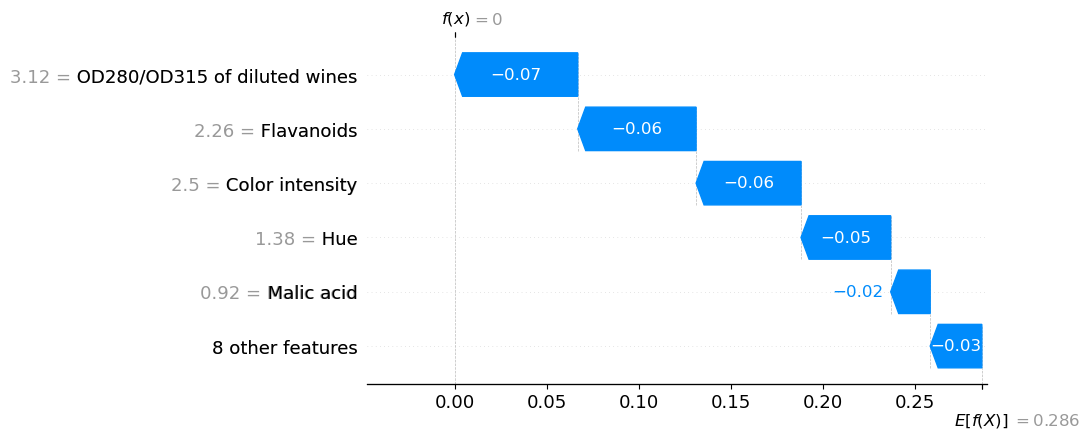

In [34]:
shap.plots.waterfall(ex[0,:,2], max_display=6)

We can also plot the relationship between certain features and their shap values. To do that, we ask the explainer to produce explanations for the whole testing set.

In [35]:
explanations = explainer(X_test)

Here is then how to plot the relationship of the first, seventh, thirteenth features and their shap values for the class 1

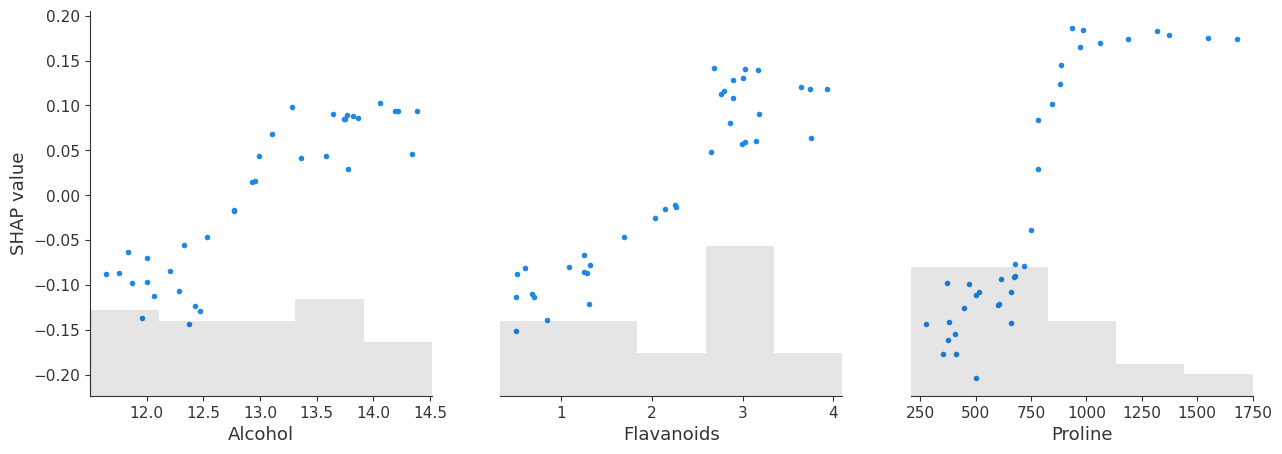

In [36]:
shap.plots.scatter(explanations[:, [0, 6, 12], 0])

And we can even use the force plot using multiple explanations. This is one plot where JavaScript is needed.

In [37]:
shap.force_plot(explanations[:,:,0])

Another important plot is the beeswarm plot. Here it is for all explanations.

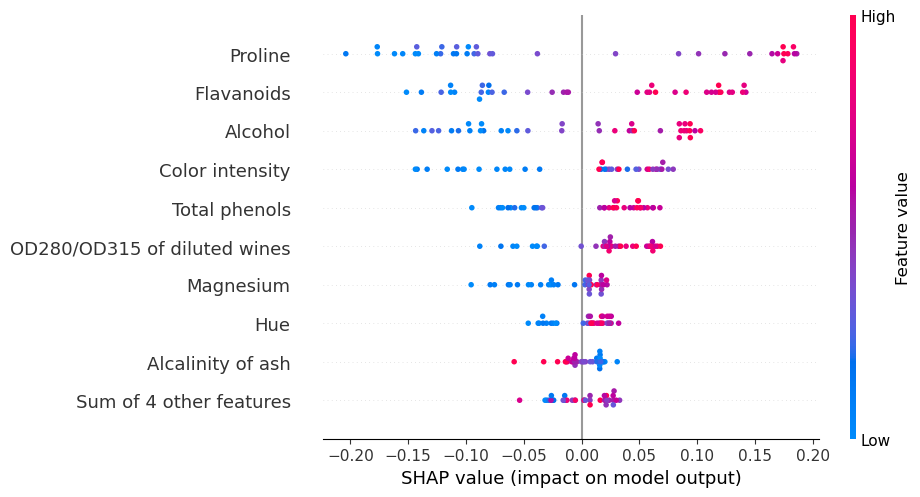

In [38]:
shap.plots.beeswarm(explanations[:,:,0])

Finally we look at the partial dependence plot (PDP). The partial dependence plot (short PDP or PD plot) shows the marginal effect one feature has on the predicted outcome of the model). It can show whether the relationship between the target and a feature is linear, monotonic or more complex. 

Here is the PDP for the seventh feature.

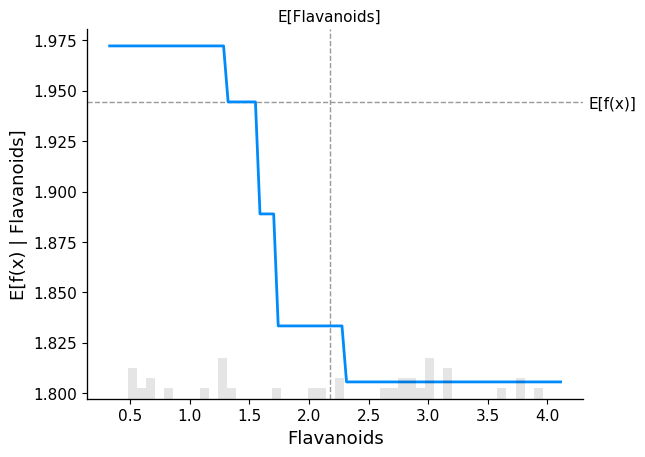

In [39]:
shap.partial_dependence_plot(
    6,
    rf.predict,
    X_test,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
    feature_names=feature_names
)

### SHAP values: Another example

The above example was of multi-class classification. Let's see a regression example. We'll use the California housing dataset. And this time we'll use Pandas dataframes

In [40]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing(as_frame=True)
X, y = california.data, california.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape

((16512, 8), (4128, 8))

Next we fit a linear regression model on this data:

In [41]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, y_train)

Here is the $R^2$ score of this model indicating how of the data variability is explained by the model.

In [42]:
model.score(X_test, y_test)

0.5995482485679573

Next we create an explainer object. We'll use the `shap.LinearExplainer` for this. The testing set has thousands of examples. So we'll only use a 50-example sample of it.

In [43]:
X_sample = shap.utils.sample(X_test, 50)

explainer = shap.LinearExplainer(model, X_sample)
explanations = explainer(X_sample)

Here is the force plot of the first example in the sample set.

In [44]:
shap.force_plot(explanations[0])

And here is its waterfall plot:

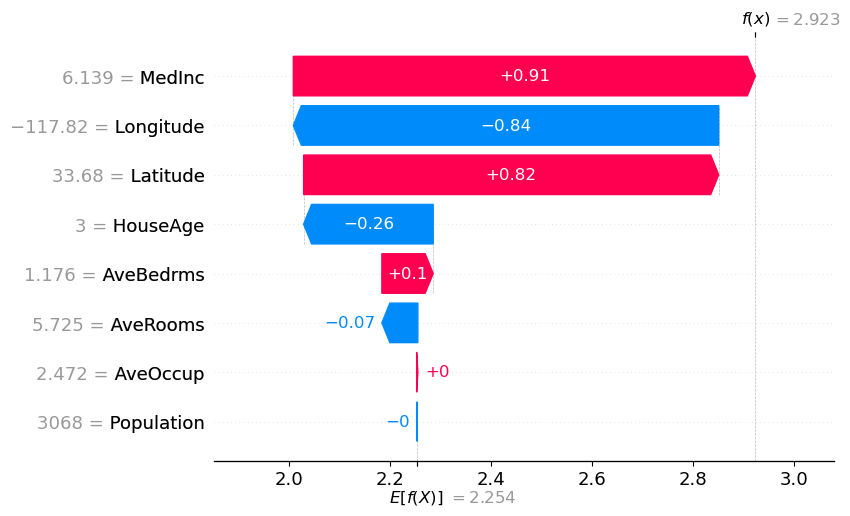

In [45]:
shap.waterfall_plot(explanations[0])

Compare the directions of the shap values of this example to that of model coefficients below:

In [46]:
pd.Series(model.coef_, index=california.feature_names)

MedInc        4.443380e-01
HouseAge      9.695837e-03
AveRooms     -1.183633e-01
AveBedrms     7.707760e-01
Population   -5.227707e-07
AveOccup     -4.679375e-03
Latitude     -4.302839e-01
Longitude    -4.436301e-01
dtype: float64

Here is the force plot for all the sample explanations:

In [47]:
shap.force_plot(explanations)

And the beeswarm plot:

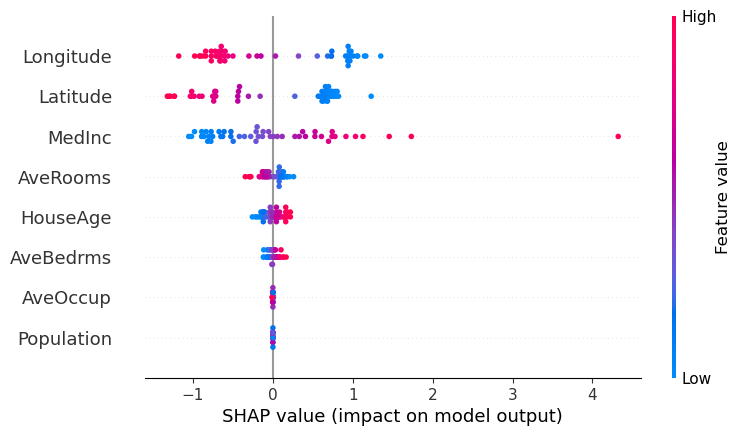

In [48]:
shap.plots.beeswarm(explanations)

And here is the feature importance bar plot.

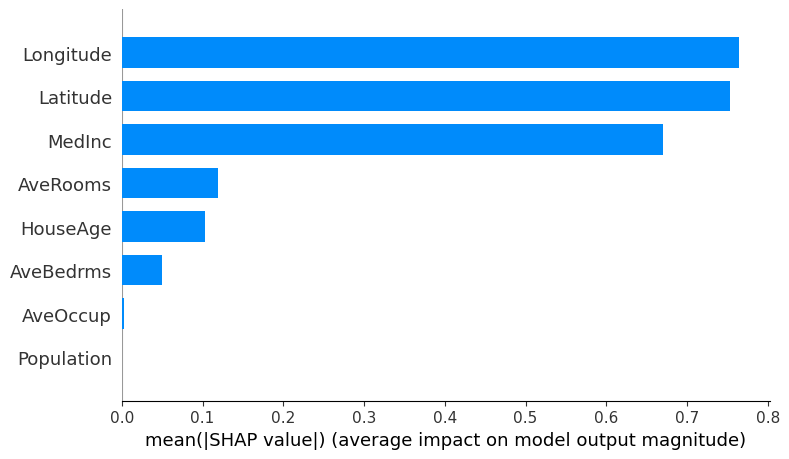

In [49]:
shap.summary_plot(explanations, plot_type="bar")

Finally, let's see the PDP of the Median Income feature (MedInc):

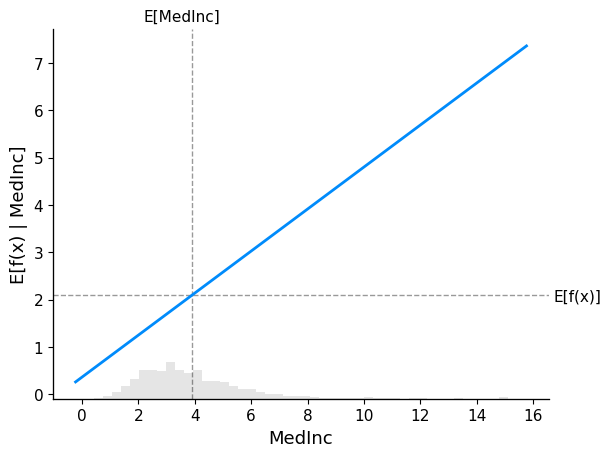

In [50]:
shap.partial_dependence_plot(
    0,
    model.predict,
    X_test,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

### For more information
For more information about the `shap` package, refer to its documentation site at https://shap.readthedocs.io/en/latest/.

## Hyperparameter tuning using Optuna

Hyperparameters are a set of variables that control the behavior of the models outside the data. 

### Studies, trials, and objective functions
Optuna makes automating hyper-parameter tuning super easy. Optuna uses the concepts of **trials** and **studies** and **objective functions**. A **trial** is a single evaluation of a machine learning model with a specific set of hyperparameters. It represents a single run or experiment in which a machine learning model is trained and evaluated using a particular combination of hyperparameters. The goal of each trial is to optimize a specific **objective function**, such as minimizing the mean squared error in a regression problem or maximizing accuracy in a classification problem. Optuna keeps track of the results from multiple trials to help find the best hyperparameters for your model.

A **study**, is a set of trials. It manages and orchestrates the optimization process. A study defines the search space for hyperparameters and the optimization strategy, such as Bayesian optimization. Within a study, Optuna performs various trials with different hyperparameter combinations to find the optimal set of hyperparameters that yield the best results for your machine learning model. You can create and manage multiple studies, each of which may have its own set of trials and objective functions.

To see how this work, let's use wine dataset again:

In [51]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None, names=[
    'y', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 
    'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
    'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline'
])

df = df[[*df.columns[1:], df.columns[0]]]

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1].values, df.iloc[:, -1].values, test_size=0.2)

To use Optuna, we must define an objective function first. This is a user-defined function that serves as the basis for the optimization process. The objective function takes a trial parameter as input and returns a numerical value that Optuna aims to minimize or maximize, depending on whether you are dealing with a minimization or maximization problem. This function also defines the hyperparameters being tuned and the values they can possibly take.

Here is an example objective function for tuning the hyper-parameters of a random forest model using the above wine data. This function returns the accuracy of the trial. Notice that this function plugs into Optuna's utilities through the trial parameter.

In [52]:
import optuna
import warnings
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

optuna.logging.set_verbosity(optuna.logging.ERROR)
warnings.filterwarnings('ignore')

optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    r_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'bootstrap': False,
        'oob_score': False,
        'warm_start': trial.suggest_categorical('warm_start', [True, False]),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'random_state': 17
    }

    X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=.2)
    model = RandomForestClassifier(**r_params)
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_va)

    ac = accuracy_score(y_va, y_pred)
    f1 = f1_score(y_va, y_pred, average="macro")
    

    trial.set_user_attr('accuracy', ac)
    trial.set_user_attr('f1', f1)

    return ac

Next we define a study. We it give a name, indicate its direction, and specify its **sampler** and **pruner**. Both the sampler and pruner are essential for efficient and effective hyperparameter optimization in Optuna. The sampler defines how the search space is explored, while the pruner ensures that unpromising trials are terminated early, allowing the optimization process to focus on more promising hyperparameter configurations.

Because the objective function returns accuracy, the direction of this study is `maximize`.

In [53]:
study = optuna.create_study(**{
    'study_name': 'wine-study',
    'direction': 'maximize',
    'sampler': optuna.samplers.TPESampler(seed=37),
    'pruner': optuna.pruners.MedianPruner(n_warmup_steps=10)
})

We are now ready to call the `optimize` function of the study. This is the function that actually performs the hyper-parameter tuning. We'll do 100 trials. This is also where we link the study to the objective function.

In [54]:
study.optimize(**{
    'func': objective,
    'n_trials': 100,
    'n_jobs': 1,
    'show_progress_bar': False
})

Having done that, here are the resulting best parameters

In [55]:
study.best_params

{'n_estimators': 171,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'criterion': 'gini',
 'warm_start': False,
 'ccp_alpha': 0.0400942675872602,
 'max_depth': 83}

And we are not ready to fit a tuned model using these best values. We'll display its confusion matrix.

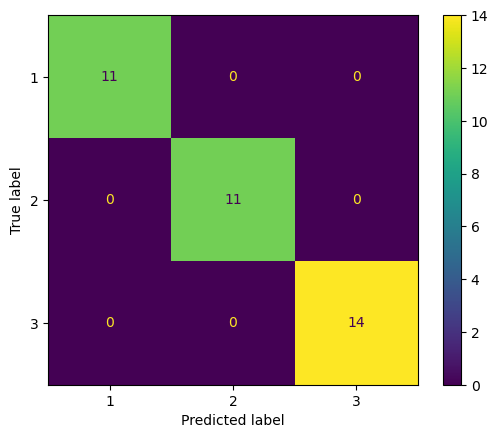

In [56]:
tuned_rf = RandomForestClassifier(**study.best_params).fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(tuned_rf, X_test, y_test)

Finally, let's take a look at the hyper-parameter tuning process and use Optuna utility functions to inspect and visualize it. Here is the dataframe of all the trials:

In [57]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.413793 2023-11-06 10:01:00.271887 2023-11-06 10:01:00.456363   
1        1  0.931034 2023-11-06 10:01:00.456547 2023-11-06 10:01:00.556852   
2        2  1.000000 2023-11-06 10:01:00.557095 2023-11-06 10:01:00.703202   
3        3  0.482759 2023-11-06 10:01:00.703350 2023-11-06 10:01:00.828927   
4        4  1.000000 2023-11-06 10:01:00.829078 2023-11-06 10:01:00.961545   
..     ...       ...                        ...                        ...   
95      95  0.965517 2023-11-06 10:01:14.699070 2023-11-06 10:01:14.857300   
96      96  1.000000 2023-11-06 10:01:14.857468 2023-11-06 10:01:15.033728   
97      97  0.896552 2023-11-06 10:01:15.033898 2023-11-06 10:01:15.205699   
98      98  1.000000 2023-11-06 10:01:15.205869 2023-11-06 10:01:15.310547   
99      99  0.965517 2023-11-06 10:01:15.310716 2023-11-06 10:01:15.467348   

                 duration  params_ccp_alpha params_criterion  \
0  0 days 00:00:00.184476          0.792706         log_loss   
1  0 days 00:00:00.100305          0.117029         log_loss   
2  0 days 00:00:00.146107          0.040094             gini   
3  0 days 00:00:00.125577          0.752074         log_loss   
4  0 days 00:00:00.132467          0.331351          entropy   
..                    ...               ...              ...   
95 0 days 00:00:00.158230          0.112019          entropy   
96 0 days 00:00:00.176260          0.137805          entropy   
97 0 days 00:00:00.171801          0.068436         log_loss   
98 0 days 00:00:00.104678          0.021697          entropy   
99 0 days 00:00:00.156632          0.152450          entropy   

    params_max_depth params_max_features  params_min_samples_leaf  \
0                 63                log2                        2   
1                 37                log2                        9   
2                 83                sqrt                        4   
3                 47                sqrt                        9   
4                 48                log2                        7   
..               ...                 ...                      ...   
95                93                sqrt                        5   
96                56                log2                        6   
97                30                sqrt                        3   
98                44                sqrt                        5   
99                25                log2                        3   

    params_min_samples_split  params_n_estimators  params_warm_start  \
0                          6                  192              False   
1                         10                  116              False   
2                         10                  171              False   
3                          2                  146               True   
4                          2                  156               True   
..                       ...                  ...                ...   
95                        10                  146               True   
96                         8                  169               True   
97                         2                  160              False   
98                         3                   86               True   
99                         5                  126              False   

    user_attrs_accuracy  user_attrs_f1     state  
0              0.413793       0.195122  COMPLETE  
1              0.931034       0.927692  COMPLETE  
2              1.000000       1.000000  COMPLETE  
3              0.482759       0.217054  COMPLETE  
4              1.000000       1.000000  COMPLETE  
..                  ...            ...       ...  
95             0.965517       0.970794  COMPLETE  
96             1.000000       1.000000  COMPLETE  
97             0.896552       0.895676  COMPLETE  
98             1.000000       1.000000  COMPLETE  
99             0.965517       0.968046  COM

Optuna also allows us to visualize the process using various plots. Here is one, plotting the optimization history. Notice that Optuna plots use the Plotly package, which you may need to install if you don't have it already. **NOTE**: Plotly can be installed using the command:

```
pip install plotly
```

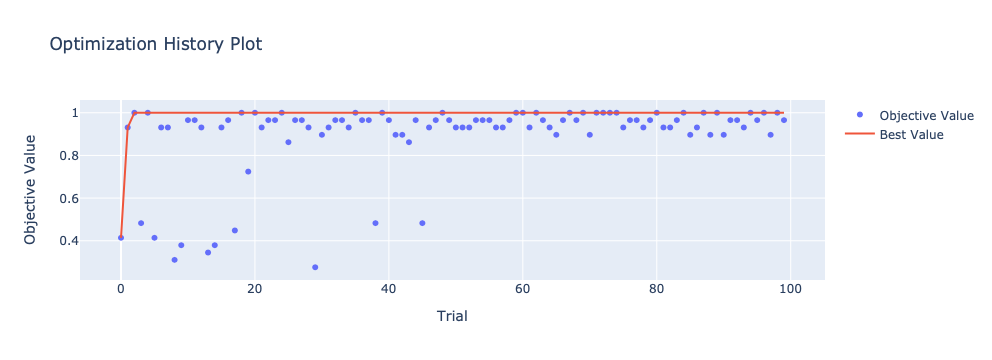

In [58]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

Here is also a bar plot indicating which of these parameters is most important.

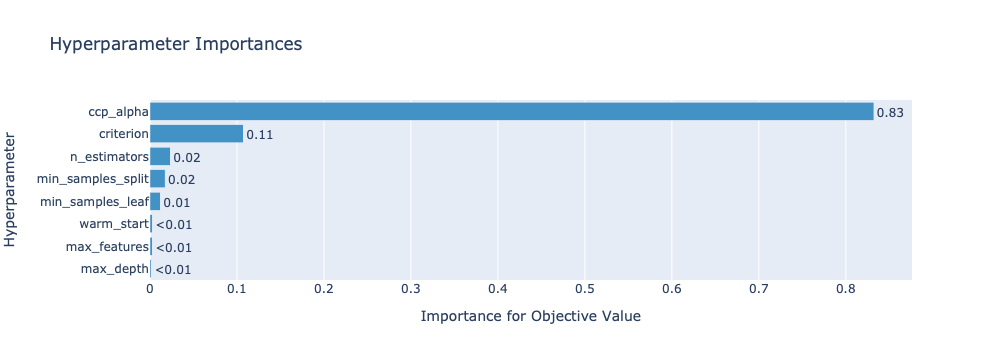

In [59]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

### Another example

In this example you will tune the parameters of an MLP model fitted to the [Hepatitis](https://archive.ics.uci.edu/dataset/46/hepatitis) dataset. This dataset is small and unbalanced. It consists of 19 input categorical and numerical features, some of which contain missing values. All input features have been converted to numeric values, and missing values are marked with a question mark `?`.

Let's load the data

In [60]:
raw_df = pd.read_csv(
    my.download_zip_and_open_a_file('https://archive.ics.uci.edu/static/public/46/hepatitis.zip', 'hepatitis.data'), 
    header=None, na_values='?', 
    names=[ "Class", "AGE", "SEX", "STEROID", "ANTIVIRALS", "FATIGUE", "MALAISE", "ANOREXIA", 
            "LIVER BIG", "LIVER FIRM", "SPLEEN PALPABLE", "SPIDERS", "ASCITES", "VARICES", 
            "BILIRUBIN", "ALK PHOSPHATE", "SGOT", "ALBUMIN", "PROTIME", "HISTOLOGY"])

df = raw_df[list(raw_df.columns[1:]) + ["Class"]]
df['Class'] = df['Class'].apply(lambda c : 0 if c == 2 else 1)
df

AGE  SEX  STEROID  ANTIVIRALS  FATIGUE  MALAISE  ANOREXIA  LIVER BIG  \
0     30    2      1.0           2      2.0      2.0       2.0        1.0   
1     50    1      1.0           2      1.0      2.0       2.0        1.0   
2     78    1      2.0           2      1.0      2.0       2.0        2.0   
3     31    1      NaN           1      2.0      2.0       2.0        2.0   
4     34    1      2.0           2      2.0      2.0       2.0        2.0   
..   ...  ...      ...         ...      ...      ...       ...        ...   
150   46    1      2.0           2      1.0      1.0       1.0        2.0   
151   44    1      2.0           2      1.0      2.0       2.0        2.0   
152   61    1      1.0           2      1.0      1.0       2.0        1.0   
153   53    2      1.0           2      1.0      2.0       2.0        2.0   
154   43    1      2.0           2      1.0      2.0       2.0        2.0   

     LIVER FIRM  SPLEEN PALPABLE  SPIDERS  ASCITES  VARICES  BILIRUBIN  \
0           2.0              2.0      2.0      2.0      2.0        1.0   
1           2.0              2.0      2.0      2.0      2.0        0.9   
2           2.0              2.0      2.0      2.0      2.0        0.7   
3           2.0              2.0      2.0      2.0      2.0        0.7   
4           2.0              2.0      2.0      2.0      2.0        1.0   
..          ...              ...      ...      ...      ...        ...   
150         2.0              2.0      1.0      1.0      1.0        7.6   
151         1.0              2.0      2.0      2.0      2.0        0.9   
152         1.0              2.0      1.0      2.0      2.0        0.8   
153         2.0              1.0      1.0      2.0      1.0        1.5   
154         2.0              1.0      1.0      1.0      2.0        1.2   

     ALK PHOSPHATE   SGOT  ALBUMIN  PROTIME  HISTOLOGY  Class  
0             85.0   18.0      4.0      NaN          1      0  
1            135.0   42.0      3.5      NaN          1      0  
2             96.0   32.0      4.0      NaN          1      0  
3             46.0   52.0      4.0     80.0          1      0  
4              NaN  200.0      4.0      NaN          1      0  
..             ...    ...      ...      ...        ...    ...  
150            NaN  242.0      3.3     50.0          2      1  
151          126.0  142.0      4.3      NaN          2      0  
152           75.0   20.0      4.1      NaN          2      0  
153           81.0   19.0      4.1     48.0          2      0  
154          100.0   19.0      3.1     42.0          2      1  

[155 rows x 20 columns]

We need to process this data as follows:
* Handle missing values using an `sklearn.impute.SimpleImputer` with a 'most frequent' strategy for categorical columns and another `sklearn.impute.SimpleImputer` with a 'mean' strategy for numerical columns.
* Standardize the data

Let's create a custom preprocessor for this:

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class CustomProrocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        n, m = X.shape
        self.cat_features = []
        self.num_features = []
        for i in range(m):
            if len(np.unique(X[:, i])) <= 3:
                self.cat_features.append(i)
            else:
                self.num_features.append(i)
                
        self.freq_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        self.mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        self.scaler = StandardScaler()
        self.fitted = False
        
        return self

    def transform(self, X, y=None):
        if self.fitted:
            X[:, self.cat_features] = self.freq_imputer.transform(X[:, self.cat_features])
            X[:, self.num_features] = self.mean_imputer.transform(X[:, self.num_features])
            X = self.scaler.transform(X)
        else:
            X[:, self.cat_features] = self.freq_imputer.fit_transform(X[:, self.cat_features])
            X[:, self.num_features] = self.mean_imputer.fit_transform(X[:, self.num_features])
            X = self.scaler.fit_transform(X)
            self.fitted = True
        
        return X

Let's split this data into training and testing sets:

In [62]:
from sklearn.model_selection import train_test_split
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((116, 19), (39, 19), (116,), (39,))

We will be using an MLP classifier. Here are the parameters we can tune:

In [63]:
from sklearn.neural_network import MLPClassifier
MLPClassifier().get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

We won't tune all of these parameters nor do we need to. We'll only tune a subset of them as you can see in the objective function below.

In [64]:
from sklearn.pipeline import make_pipeline

def objective(trial):
    mlp_params = {
        'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
        'max_iter': trial.suggest_int('max_iter', 50, 500),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-5, 1e-3, log=True),
        'hidden_layer_sizes': (
            trial.suggest_int('hidden_layer_1', 50, 200), 
            trial.suggest_int('hidden_layer_2', 50, 200),
            trial.suggest_int('hidden_layer_3', 50, 200),
        ),
        'early_stopping': False
    }

    X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=.2)
    model = make_pipeline(CustomProrocessor(), MLPClassifier(**mlp_params))
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_va)

    accuracy = accuracy_score(y_va, y_pred)
    macro_f1 = f1_score(y_va, y_pred, average="macro")
    micro_f1 = f1_score(y_va, y_pred, average="micro")

    trial.set_user_attr('accuracy', accuracy)
    trial.set_user_attr('macro_f1', macro_f1)
    trial.set_user_attr('micro_f1', micro_f1)

    return 1 - accuracy

Here the objective function returns an error value (1 - accuracy). So this is a minimization process. Let's create a study and start the tuning process.

In [65]:
study = optuna.create_study(**{
    'study_name': 'hepatitis-study',
    'direction': 'minimize',
    'sampler': optuna.samplers.RandomSampler(),
    'pruner': optuna.pruners.MedianPruner(n_warmup_steps=10)
})

study.optimize(**{
    'func': objective,
    'n_trials': 100,
    'n_jobs': 1,
    'show_progress_bar': False,
})

Here are the best parameters:

In [66]:
study.best_params

{'activation': 'identity',
 'max_iter': 55,
 'solver': 'sgd',
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.0005177966641151427,
 'hidden_layer_1': 136,
 'hidden_layer_2': 101,
 'hidden_layer_3': 183}

Here is a bar plot indicating which of these parameters is most important.

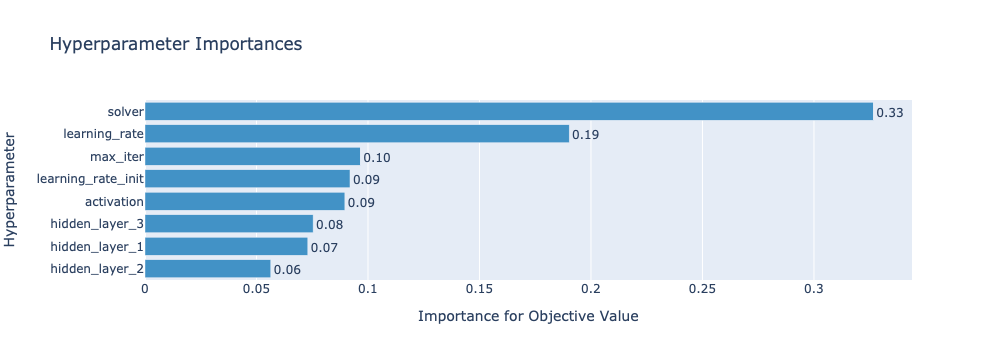

In [67]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

We can now build an MLP classifier using these best parameters and evaluate it using the testing set.

In [68]:
mlp_params = {
    'activation': study.best_params['activation'],
    'max_iter': study.best_params['max_iter'],
    'solver': study.best_params['solver'],
    'learning_rate': study.best_params['learning_rate'],
    'learning_rate_init': study.best_params['learning_rate_init'],
    'hidden_layer_sizes': (
        study.best_params['hidden_layer_1'], 
        study.best_params['hidden_layer_2'],
        study.best_params['hidden_layer_3'],
    ),
    'early_stopping': False,
    'random_state': 17
}

model = make_pipeline(
    CustomProrocessor(), 
    MLPClassifier(**mlp_params))

model.fit(X_train, y_train)

Pipeline(steps=[('customprorocessor', CustomProrocessor()),
                ('mlpclassifier',
                 MLPClassifier(activation='identity',
                               hidden_layer_sizes=(136, 101, 183),
                               learning_rate='adaptive',
                               learning_rate_init=0.0005177966641151427,
                               max_iter=55, random_state=17, solver='sgd'))])

Let's evaluate this model:

Accuracy: 0.8461538461538461 
Recall: 0.4444444444444444 
Precision: 0.8


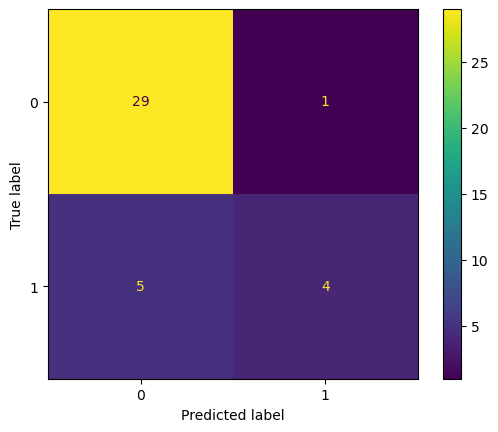

In [69]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(
    "Accuracy:", accuracy_score(y_test, model.predict(X_test)),
    "\nRecall:", recall_score(y_test, model.predict(X_test)),
    "\nPrecision:", precision_score(y_test, model.predict(X_test))
)

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

### For more information
For more information about the `optuna` package, refer to its documentation site at https://optuna.readthedocs.io/en/latest/.